In [8]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [9]:
WIDTH = 100
BOUNDS = (0,WIDTH-1)
GOAL = (60,70)

class Agent:
    def __init__(self,pos=(0,0)):
        self.traj = [] #trajectory over time
        self.pos = pos #position
        self.tdErrors = []

    def walk(self, action):
        #Add velocity to current position
        newPos = tuple(min(max(sum(i),BOUNDS[0]),BOUNDS[1]) for i in zip(self.pos,action))
        self.traj.append([self.pos,action,newPos])
        self.pos = newPos

        if newPos == GOAL:
            return True
        return False

    def getTrajectory(self):
        return self.traj

    def getPos(self):
        return self.pos

    def getTdErrors(self):
        return self.tdErrors
    
    def reset(self):
        self.traj = []
        self.pos = (0,0)

In [10]:
def getBestAction(V,s):
    availableActions = []
        #assume first index in y and second is x
    if s[0] != 0:
        availableActions.append((-1,0))
    if s[0] != WIDTH-1:
        availableActions.append((1,0))
    if s[1] != 0:
        availableActions.append((0,-1))
    if s[1] != WIDTH-1:
        availableActions.append((0,1))

    if random.random() > EPSILON:
        #do greedy action
        vMax = -np.inf
        bestAction = None
        for action in availableActions:
            v = V[tuple(map(sum,zip(s,action)))]
            if v > vMax:
                bestAction = action
                vMax = v
        if bestAction == None:
            raise ValueError('No actions were available from this state. This should never happen')
        return bestAction 
    else:
        return availableActions[random.randint(0,len(availableActions)-1)]

In [11]:
EPSILON = .1
ALPHA = .1
N = 20 #number of steps to count rewards
EPISODES = 100
RUNS = 400

def algorithm(sumTD):
    agent = Agent()
    allEpisodeLengths = []
    for _ in range(RUNS):
        V = np.random.rand(WIDTH,WIDTH)
        episodeLengths = []
        for k in range(EPISODES):
            t = 0
            stopCounting = False
            finished = False
            tdErrors = []
            while(True):
                if not finished:
                    pos = agent.getPos()
                    action = getBestAction(V,pos)
                    finished = agent.walk(action)
                    if sumTD == True:
                        traj = agent.getTrajectory()
                        # print(V[traj[-1][0]])
                        # print(V[traj[-1][2]])
                        # print()
                        tdErrors.append(deepcopy(-1 + V[traj[-1][2]] - V[traj[-1][0]]))
                    if finished:
                        stopCounting = True
                
                traj = agent.getTrajectory()

                if t >= N:
                    if sumTD == True:
                        V[traj[0][0]] += ALPHA * sum(tdErrors)
                        tdErrors.pop(0)
                    else:
                        if finished: 
                            V[traj[0][0]] += ALPHA * (-1 * (len(traj)-1) - V[traj[0][0]])
                        else:
                            V[traj[0][0]] += ALPHA * (-1 * (len(traj)-1) + V[traj[-1][0]] - V[traj[0][0]])
                    traj.pop(0)

                if finished and len(traj) == 0:
                    agent.reset()
                    break

                if not stopCounting:
                    t += 1
            episodeLengths.append(t)
        allEpisodeLengths.append(episodeLengths)
    allEpisodeLengths = np.asarray(allEpisodeLengths)
    return np.average(allEpisodeLengths, axis=0)

In [12]:
nStepResults = algorithm(False)

In [13]:
sumTDResults = algorithm(True)

In [24]:
diff = nStepResults / sumTDResults
avgDiff = np.mean(diff)

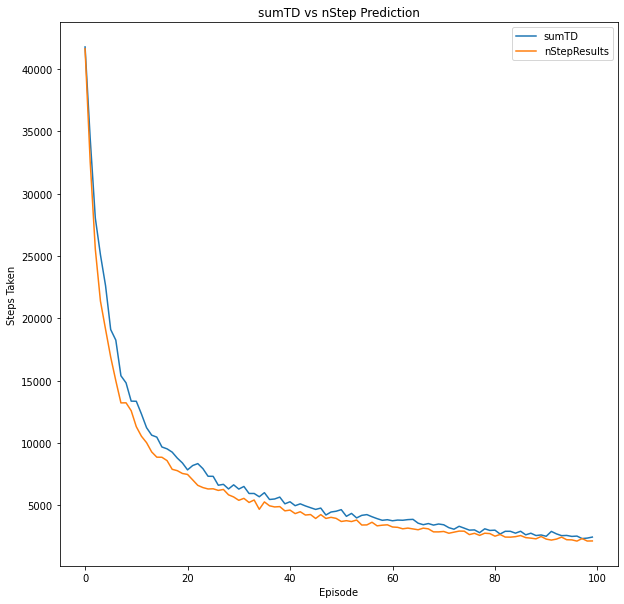

In [35]:
plt.figure(figsize=(10,10))
plt.plot(sumTDResults,label="sumTD" )
plt.plot(nStepResults,label="nStepResults")
plt.xlabel("Episode")
plt.ylabel("Steps Taken")
plt.title("sumTD vs nStep Prediction")
plt.legend()
plt.savefig("../figures/exercise7-2/sumTDvsnStepPrediciton")

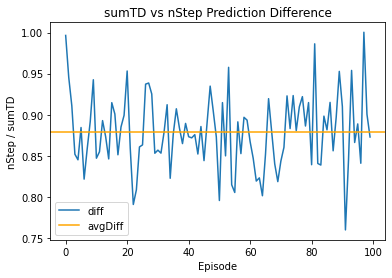

In [36]:
plt.plot(diff,label="diff" )
# plt.plot(avgDiff,label="avgDiff")
plt.axhline(y=avgDiff,label="avgDiff",color="orange")
plt.title("sumTD vs nStep Prediction Difference")
plt.xlabel("Episode")
plt.ylabel("nStep / sumTD")
plt.legend()
plt.savefig("../figures/exercise7-2/sumTDvsnStepPredicitonDifference")